In [11]:
# devtools::load_all('.')

In [1]:
library(tidyverse)
library(data.table)
library(magrittr)
library(harmony)
# library(singlecellmethods)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: Rcpp



In [2]:
normalizeData <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}

In [10]:
# X <- Matrix::t(harmony::ctrl.sparse)
X <- Matrix::cbind2(harmony::ctrl.sparse, harmony::stim.sparse)
X %<>% normalizeData()
X_ctrl <- normalizeData(harmony::ctrl.sparse)
X_stim <- normalizeData(harmony::stim.sparse)

ERROR: Error: 'ctrl.sparse' is not an exported object from 'namespace:harmony'


In [5]:
system.time({
    .res <- findVariableGenes(X, c(rep("ctrl", ncol(harmony::ctrl.sparse)), rep("stim", ncol(harmony::stim.sparse))))
#     .res <- findVariableGenes(X_ctrl, rep(0, ncol(X_ctrl)))
})

.res %>% head

   user  system elapsed 
  0.910   0.121   1.033 

symbol,group,gene_mean,gene_dispersion
HBB,stim,4.1808181,8.741350
HBB,ctrl,4.0482791,8.721871
IGLL5,stim,0.7199632,7.981911
HBA2,ctrl,2.7746718,7.428170
HBA2,stim,2.8167331,7.379681
HBG1,ctrl,0.4015790,7.132338


# kmeans

In [4]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}
library(mvtnorm)
library(tidyverse)

In [4]:
# Rcpp::sourceCpp('src/kmeans.cpp')

In [5]:
# ## colums are observations
# soft_kmeans <- function(X, k, max_iter=20, sigma=0.1) {
#     message('WARNING: soft_kmeans fxn uses cosine distance only')
#     Z <- cosine_normalize_cpp(X, 2)
#     Y <- stats::kmeans(t(Z), centers = k, iter.max = 25, nstart = 10)$centers %>% t() ## D x K
#     res <- soft_kmeans_cpp(Y, Z, max_iter, sigma)
#     return(res)
# }

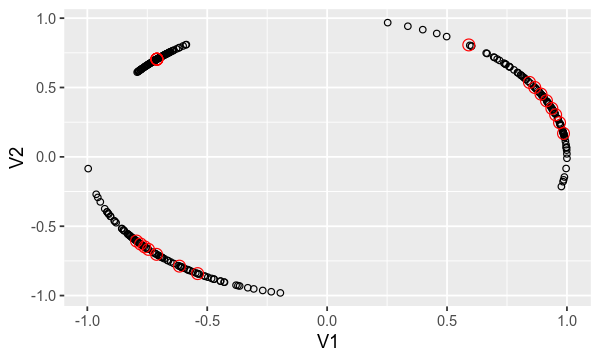

In [5]:
fig.size(3, 5)
X <- rbind(
    rmvnorm(100, mean = c(1, .5), sigma = diag(.1, 2)),
    rmvnorm(100, mean = c(-1, -1), sigma = diag(.1, 2)),
    rmvnorm(100, mean = c(-1, 1), sigma = diag(.01, 2))
) %>% 
    cosine_normalize_cpp(1) %>% 
    t()

res <- soft_kmeans(X, 21)
data.table(t(X)) %>% 
    ggplot(aes(V1, V2)) + geom_point(shape = 21) + 
    geom_point(data = data.table(t(res$Y)), color = 'red', shape = 21, size = 3)

In [10]:
devtools::install_github('immunogenomics/singlecellmethods')


✔  checking for file ‘/tmp/Rtmp8KiS4B/remotes4d752bc0a3f7/immunogenomics-singlecellmethods-ba00160/DESCRIPTION’
─  preparing ‘singlecellmethods’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  excluding invalid files
   Subdirectory 'R' contains invalid file names:
     ‘Untitled.ipynb’
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘singlecellmethods_0.1.0.tar.gz’
   


# weighted soft kmeans

In [92]:
## Test: weighted vs unweighted

In [4]:
sourceCpp('src/temp.cpp')

In [5]:
soft_kmeans <- function(X, k, w, sigma=0.1, iter.max=25, nstart=10, tol=1e-3) {
    message('WARNING: soft_kmeans fxn uses cosine distance only')
    Z <- singlecellmethods:::cosine_normalize_cpp(X, 2)
    seeds <- sample(1e6, nstart)
    if (!missing(w)) {
        score_curr <- Inf
        for (iter in seq_len(nstart)) {
            set.seed(seeds[iter])
            mediods <- sample(ncol(Z), k, prob = w)
            res_new <- soft_kmeans_weighted_cpp(Z[, mediods], Z, w, iter.max, sigma, tol)
            score_new <- tail(res_new$scores, 1)
            if (score_new < score_curr) {
                res <- res_new
                score_curr <- score_new
            }
        }
    } else {
        Y <- stats::kmeans(t(Z), k, iter.max, nstart)$centers %>% t() ## D x K
        res <- soft_kmeans_cpp(Y, Z, iter.max, sigma)        
    }
    return(res)
}



In [8]:
data(cell_lines)

table(cell_lines$meta_data$cell_type)

idx <- c(
    which(cell_lines$meta_data$cell_type == 'jurkat') %>% sample(100),
    which(cell_lines$meta_data$cell_type == 't293') %>% sample(100)
)
y <- cell_lines$meta_data$cell_type[idx]
X <- t(cell_lines$scaled_pcs[idx, 1:10])


jurkat   t293 
  1266   1104 

## Test 1: accuracy

In [9]:
sourceCpp('src/temp.cpp')

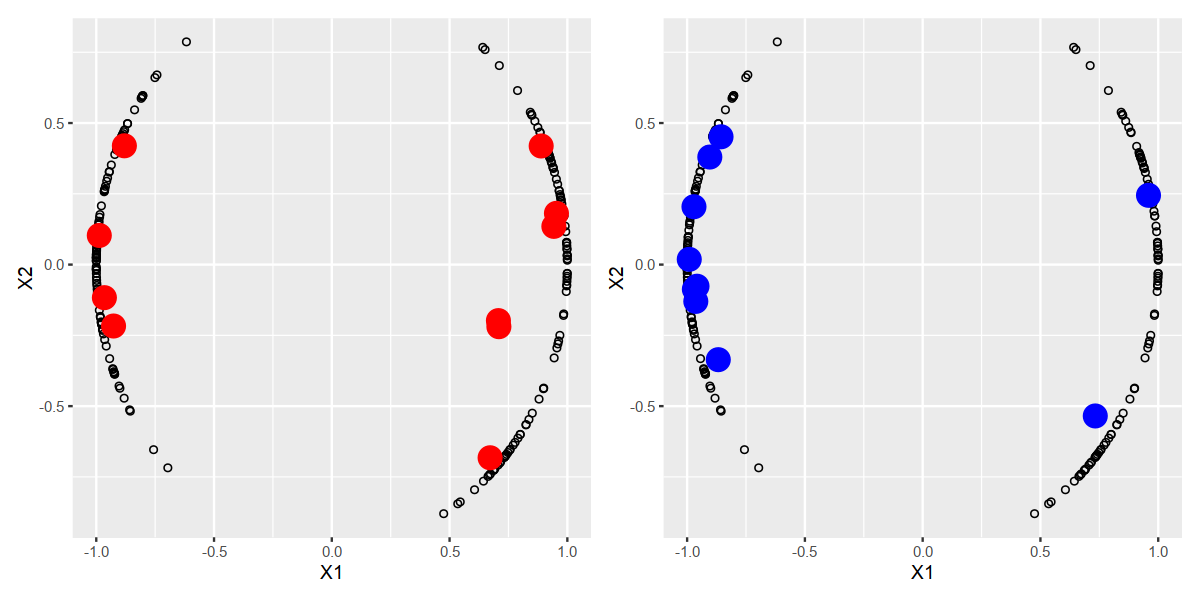

In [10]:
library(patchwork)
k <- 10
# y <- factor(y)
# weights <- as.numeric((1/prop.table(table(y)))[y])/nlevels(y)
weights <- rep(c(1, 10), c(100, 100)) %>% prop.table()
set.seed(4)
mediods <- sample(ncol(X), k)
# mediods <- c(1, 2)
# mediods
# resw <- soft_kmeans_weighted_cpp(X[, mediods], X, weights, 30, .1, 1e-4)
resw <- soft_kmeans(X, k, weights)
# resw <- soft_kmeans_weighted_cpp(X[, c(1), drop = FALSE], X, weights, 30, .1, 1e-4)
res <- singlecellmethods:::soft_kmeans(X, k, sigma = .1, max_iter = 30)

fig.size(5, 10)
# res$Y
plt <- t(X)[, 1:2] %>% 
    singlecellmethods:::cosine_normalize_cpp(1) %>%  
    data.frame() %>% 
    ggplot(aes(X1, X2)) + 
        geom_point(shape = 21) + 
        NULL
plt + 
    geom_point(size = 6, data = data.frame(t(res$Y[1:2, ])), color = 'red') +
plt +
    geom_point(size = 6, data = data.frame(t(resw$Y[1:2, ])), color = 'blue') +
NULL


In [11]:
library(singlecellmethods)
Z <- singlecellmethods:::cosine_normalize_cpp(X, 1)
dist_mat <- 2 * (1 - crossprod(res$Y, Z))
dist_mat_w <- 2 * (1 - crossprod(resw$Y, Z))
soft_kmeans_score_cpp(res$R, weights, dist_mat, .1)
# soft_kmeans_score_cpp(res$R, rep(1/200, 200), dist_mat, .1)
soft_kmeans_score_cpp(resw$R, weights, dist_mat_w, .1)


Attaching package: ‘singlecellmethods’


The following objects are masked _by_ ‘.GlobalEnv’:

    normalizeData, soft_kmeans


The following object is masked from ‘package:base’:

    rowMeans




[1] 1.721948

[1] 1.668858

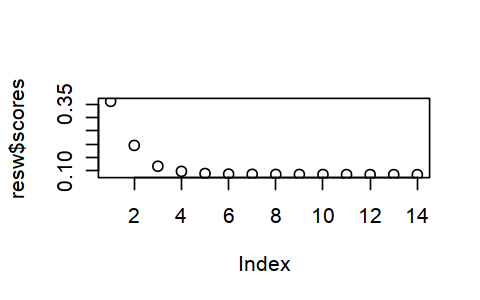

In [12]:
fig.size(2.5, 4)
plot(resw$scores)

In [13]:
# diff(resw$scores) / head(resw$scores, -1)

## Test 2: speed

In [14]:
sourceCpp('src/temp.cpp')

In [20]:
data(cell_lines)

# idx <- c(
#     which(cell_lines$meta_data$cell_type == 'jurkat') %>% sample(100),
#     which(cell_lines$meta_data$cell_type == 't293') %>% sample(100)
# )
# idx <- 1:nrow(cell_lines$meta_data)
y <- cell_lines$meta_data$cell_type
X <- t(cell_lines$scaled_pcs)

dim(X)
X <- list(c(X, X, X, X, X, X, X, X, X, X, X)) %>% purrr::reduce(rbind) %>% matrix(nrow = 20)
dim(X)
X <- X[, 1:1e4]

[1]   20 2370

[1]    20 26070

In [21]:
k <- 100

In [22]:
system.time({
    flexclust::cclust(t(X), k, method='hardcl', weights=weights)
})
    

   user  system elapsed 
 55.118   0.022  55.535 

In [23]:
system.time({
    resw <- soft_kmeans(X, k, rep(1, ncol(X)), nstart = 10, iter.max = 20)
})

   user  system elapsed 
 72.694 179.851  11.035 

In [24]:
system.time({
# profvis({
    resw <- stats::kmeans(t(X), k, nstart = 10, iter.max = 20)#soft_kmeans(X, k, rep(1, ncol(X)), nstart = 1)
})

   user  system elapsed 
  0.853   0.000   0.854 

In [26]:
# stats::kmeans

## Test 3: part of package

In [82]:
devtools::load_all('/data/srlab/ik936/harmony')

Loading harmony



In [54]:
data(cell_lines)
y <- cell_lines$meta_data$dataset
y <- factor(y)
weights <- as.numeric((1/prop.table(table(y)))[y])/nlevels(y)


In [83]:
weights <- rep(1, nrow(cell_lines$meta_data))
harmonyObj <- HarmonyMatrix(
    cell_lines$scaled_pcs,
    cell_lines$meta_data,
    c('dataset'),
    weights = weights, 
    use_weights_init = TRUE, 
    do_pca = FALSE,
    return_object = TRUE
)


Harmony 1/10

Harmony converged after 1 iterations



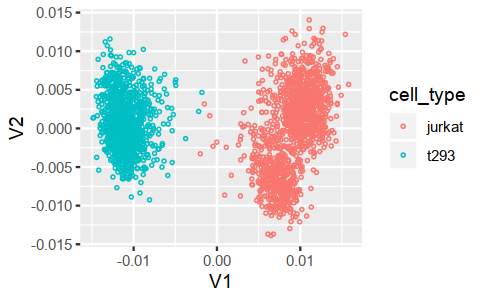

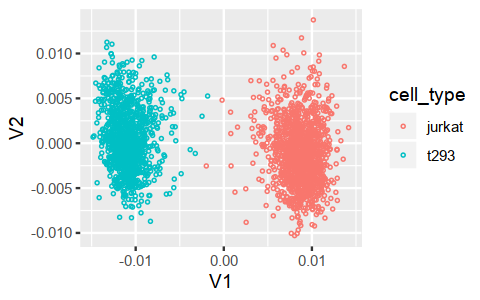

In [93]:
harmonyObj$Z_orig[1:2, ] %>% 
    t() %>% data.table() %>% 
    cbind(cell_lines$meta_data) %>% 
    ggplot(aes(V1, V2, color = cell_type)) + 
        geom_point(shape = 21, size = .5) + 
        NULL

harmonyObj$Z_corr[1:2, ] %>% 
    t() %>% data.table() %>% 
    cbind(cell_lines$meta_data) %>% 
    ggplot(aes(V1, V2, color = cell_type)) + 
        geom_point(shape = 21, size = .5) + 
        NULL


In [74]:
weights <- rep(1, ncol(X))
resw <- soft_kmeans_weighted_cpp(X[, c(1, 5, 10, 332, 281, 382)], X, weights, 20, .1, 1e-4)
